# 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import os 
import glob
import cv2
import itertools

from dataloader_distance import *

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Linear Regression : Only Distance

### 데이터 불러오기

In [3]:
file_path = "D:\gait_dataset/salted/train/*"
_, _, stride_length = get_sensor_salted(file_path, bias=)
inputs_pst = get_position_salted(file_path, distance=True)

SyntaxError: invalid syntax (849059510.py, line 2)

In [141]:
train = pd.DataFrame(inputs_pst)
train.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']
train

,R_DIS_X,R_DIS_Y,R_DIS_Z
0,0.325056,0.295638,0.591209
1,0.408169,0.226372,0.594593
2,0.385037,0.185862,0.569153
3,0.432047,0.206133,0.605114
4,0.483833,0.175300,0.620395
...,...,...,...
3348,0.586512,0.318631,0.656599
3349,0.603322,0.399322,0.698904
3350,0.649342,0.543410,0.669275
3351,0.533692,0.235974,0.705292


In [142]:
x_train, x_test, y_train, y_test = train_test_split(train, stride_length, train_size=0.8, test_size=0.2)

In [143]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [144]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

12.21255178476683

Text(0, 0.5, 'y_pred')

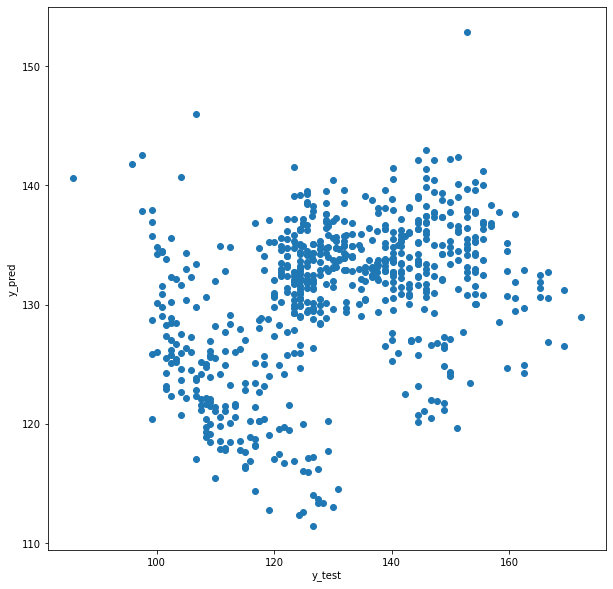

In [149]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")

# Encoder-based Model : Acc, Gyro 각각 입력, 최종 노드 1개
- Encoder로 Conv1d와 LSTM을 활용

## 데이터 불러오기

In [112]:
file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [113]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

## Encoder

In [114]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, lstm_hidden):
        super(Encoder, self).__init__()
        
        self.lstm_hidden = lstm_hidden
        
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_dim1, hidden_dim2, 30),
            nn.ReLU(inplace=True)
        )
        
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_dim1, hidden_dim2, 30),
            nn.ReLU(inplace=True)
        )
        
        self.lstm_acc = nn.LSTM(hidden_dim2, lstm_hidden, 1, batch_first=True)
        self.lstm_gyr = nn.LSTM(hidden_dim2, lstm_hidden, 1, batch_first=True)
            
#         self.encoder_pres = nn.Sequential(
#             nn.Conv1d(input_dim, hidden_dim1, 7),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(hidden_dim1, hidden_dim2, 7),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(hidden_dim2, hidden_dim3, 7),
#             nn.ReLU(inplace=True),
#             nn.Flatten()
#         )
        
        self.dense = nn.Sequential(
            nn.Linear(lstm_hidden*2, hidden_dim2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim1, 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        h0 = torch.zeros(1, inputs_acc.size(0), lstm_hidden).to(device)
        c0 = torch.zeros(1, inputs_acc.size(0), lstm_hidden).to(device)
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc).transpose(1, 2)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr).transpose(1, 2)
        
        _, (enc_output_acc, _) = self.lstm_acc(conv1d_output_acc)
        _, (enc_output_gyr, _) = self.lstm_gyr(conv1d_output_gyr)
        
        enc_output = torch.concat((enc_output_acc[-1], enc_output_gyr[-1]), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [115]:
input_dim = 3
hidden_dim1 = 16
hidden_dim2 = 32
lstm_hidden = 64

model = Encoder(input_dim, hidden_dim1, hidden_dim2, lstm_hidden).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [116]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './encoder_1_best.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 17201.375884, Valid Loss 16675.411133, MAE 126.224113
Epoch : 2/2000, Train Loss : 16004.461217, Valid Loss 14655.044596, MAE 118.073380
Epoch : 3/2000, Train Loss : 13150.166574, Valid Loss 10929.341797, MAE 101.368546
Epoch : 4/2000, Train Loss : 8687.874279, Valid Loss 5912.042074, MAE 73.206886
Epoch : 5/2000, Train Loss : 3780.449550, Valid Loss 1687.184591, MAE 35.624977
Epoch : 6/2000, Train Loss : 827.841428, Valid Loss 308.607101, MAE 14.206922
Best Valid Loss 308.6071
Epoch : 7/2000, Train Loss : 298.328497, Valid Loss 305.259984, MAE 15.158953
Best Valid Loss 305.2600
Epoch : 8/2000, Train Loss : 296.038952, Valid Loss 288.341156, MAE 14.529314
Best Valid Loss 288.3412
Epoch : 9/2000, Train Loss : 290.556000, Valid Loss 287.103828, MAE 14.358686
Best Valid Loss 287.1038
Epoch : 10/2000, Train Loss : 290.837770, Valid Loss 287.448514, MAE 14.424466
Epoch : 11/2000, Train Loss : 290.813355, Valid Loss 287.314822, MAE 14.399085
Epoch : 12/2000, Trai

Epoch : 90/2000, Train Loss : 78.714640, Valid Loss 75.880547, MAE 6.926900
Best Valid Loss 75.8805
Epoch : 91/2000, Train Loss : 76.541083, Valid Loss 69.949557, MAE 6.258280
Best Valid Loss 69.9496
Epoch : 92/2000, Train Loss : 72.783320, Valid Loss 66.446395, MAE 6.000787
Best Valid Loss 66.4464
Epoch : 93/2000, Train Loss : 71.359005, Valid Loss 64.927130, MAE 6.275733
Best Valid Loss 64.9271
Epoch : 94/2000, Train Loss : 68.378073, Valid Loss 60.428857, MAE 5.952362
Best Valid Loss 60.4289
Epoch : 95/2000, Train Loss : 66.119346, Valid Loss 57.804633, MAE 5.908447
Best Valid Loss 57.8046
Epoch : 96/2000, Train Loss : 62.921504, Valid Loss 57.143511, MAE 5.493659
Best Valid Loss 57.1435
Epoch : 97/2000, Train Loss : 62.277380, Valid Loss 67.843754, MAE 5.815252
Epoch : 98/2000, Train Loss : 60.809376, Valid Loss 52.776629, MAE 5.051280
Best Valid Loss 52.7766
Epoch : 99/2000, Train Loss : 58.719264, Valid Loss 52.052625, MAE 5.645868
Best Valid Loss 52.0526
Epoch : 100/2000, Train 

Epoch : 186/2000, Train Loss : 24.813633, Valid Loss 24.223959, MAE 2.729226
Epoch : 187/2000, Train Loss : 24.829734, Valid Loss 28.116958, MAE 3.112334
Epoch : 188/2000, Train Loss : 25.831047, Valid Loss 26.800879, MAE 2.861962
Epoch : 189/2000, Train Loss : 25.734337, Valid Loss 28.576688, MAE 3.270331
Epoch : 190/2000, Train Loss : 25.651404, Valid Loss 25.814482, MAE 2.964772
Epoch : 191/2000, Train Loss : 25.254329, Valid Loss 22.622155, MAE 3.311674
Epoch : 192/2000, Train Loss : 24.612272, Valid Loss 22.981736, MAE 2.844768
Epoch : 193/2000, Train Loss : 24.902674, Valid Loss 23.076447, MAE 2.711779
Epoch : 194/2000, Train Loss : 23.569692, Valid Loss 21.310109, MAE 2.743636
Best Valid Loss 21.3101
Epoch : 195/2000, Train Loss : 25.371434, Valid Loss 27.476581, MAE 3.156260
Epoch : 196/2000, Train Loss : 24.150238, Valid Loss 21.978925, MAE 2.869984
Epoch : 197/2000, Train Loss : 23.711143, Valid Loss 21.386455, MAE 2.814504
Epoch : 198/2000, Train Loss : 23.325797, Valid Loss

Epoch : 287/2000, Train Loss : 13.215624, Valid Loss 15.812654, MAE 2.037146
Epoch : 288/2000, Train Loss : 13.443237, Valid Loss 14.219235, MAE 2.012268
Best Valid Loss 14.2192
Epoch : 289/2000, Train Loss : 13.439730, Valid Loss 15.133742, MAE 1.965369
Epoch : 290/2000, Train Loss : 14.748436, Valid Loss 18.709326, MAE 2.421384
Epoch : 291/2000, Train Loss : 15.152203, Valid Loss 14.108509, MAE 1.880726
Best Valid Loss 14.1085
Epoch : 292/2000, Train Loss : 15.693980, Valid Loss 17.289572, MAE 2.045677
Epoch : 293/2000, Train Loss : 14.244806, Valid Loss 18.100461, MAE 2.032722
Epoch : 294/2000, Train Loss : 13.745387, Valid Loss 20.932267, MAE 2.900819
Epoch : 295/2000, Train Loss : 14.559991, Valid Loss 15.958123, MAE 2.242390
Epoch : 296/2000, Train Loss : 14.740396, Valid Loss 15.420126, MAE 1.967415
Epoch : 297/2000, Train Loss : 13.711183, Valid Loss 14.500322, MAE 2.152328
Epoch : 298/2000, Train Loss : 13.458033, Valid Loss 13.749542, MAE 2.116439
Best Valid Loss 13.7495
Epoc

Epoch : 389/2000, Train Loss : 10.459258, Valid Loss 13.611595, MAE 1.922981
Epoch : 390/2000, Train Loss : 9.964761, Valid Loss 11.661786, MAE 1.645631
Epoch : 391/2000, Train Loss : 9.302418, Valid Loss 13.113135, MAE 1.814329
Epoch : 392/2000, Train Loss : 9.946221, Valid Loss 12.858347, MAE 1.873265
Epoch : 393/2000, Train Loss : 9.941198, Valid Loss 12.411138, MAE 1.929422
Epoch : 394/2000, Train Loss : 9.601582, Valid Loss 12.227029, MAE 1.811947
Epoch : 395/2000, Train Loss : 10.168884, Valid Loss 12.654873, MAE 1.985346
Epoch : 396/2000, Train Loss : 17.622933, Valid Loss 35.061311, MAE 4.603695
Epoch : 397/2000, Train Loss : 17.211003, Valid Loss 15.316375, MAE 3.178466
Epoch : 398/2000, Train Loss : 27.851111, Valid Loss 42.228612, MAE 4.200137
Epoch : 399/2000, Train Loss : 38.663912, Valid Loss 30.646578, MAE 3.731895
Epoch : 400/2000, Train Loss : 18.175655, Valid Loss 16.735364, MAE 2.514628
Epoch : 401/2000, Train Loss : 14.215968, Valid Loss 15.113202, MAE 2.410151
Epoc

## Scatter Plot

In [117]:
file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
# stride_length = stride_length.reshape(-1, 1)
# stride_length = stride_length.to(device)

In [118]:
input_dim = 3
hidden_dim1 = 16
hidden_dim2 = 32
lstm_hidden = 64

model = Encoder(input_dim, hidden_dim1, hidden_dim2, lstm_hidden).to(device)
model.load_state_dict(torch.load('./encoder_1_best.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
  )
  (lstm_acc): LSTM(32, 64, batch_first=True)
  (lstm_gyr): LSTM(32, 64, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

Text(0, 0.5, 'stride_length')

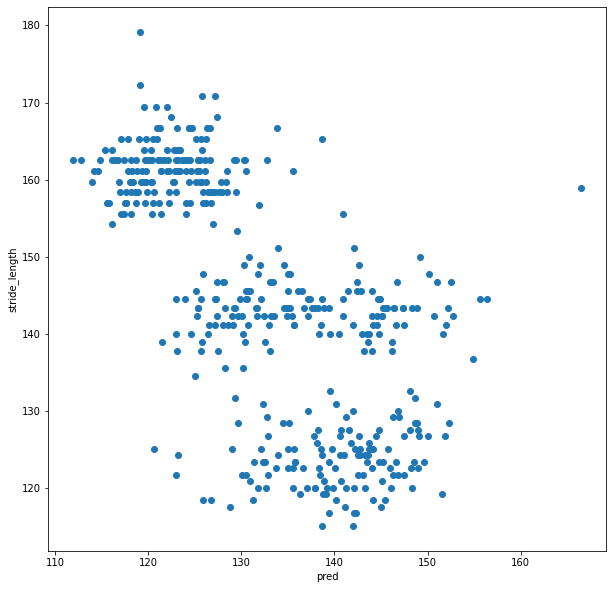

In [119]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(pred, stride_length)
plt.xlabel('pred')
plt.ylabel('stride_length')

# Encoder-based Model : Acc, Gyro 각각 입력, 최종 노드 3개
- Encoder로 Conv1d와 LSTM을 활용
- 최종적으로 출력된 노드 3개를 distance와 곱

## 데이터 불러오기

In [5]:
file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [6]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

## Encoder

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

class Encoder_dist(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, lstm_hidden):
        super(Encoder_dist, self).__init__()
        
        self.lstm_hidden = lstm_hidden
        
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_dim1, hidden_dim2, 30),
            nn.ReLU(inplace=True)
        )
        
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_dim1, hidden_dim2, 30),
            nn.ReLU(inplace=True)
        )
        
        self.lstm_acc = nn.LSTM(hidden_dim2, lstm_hidden, 1, batch_first=True)
        self.lstm_gyr = nn.LSTM(hidden_dim2, lstm_hidden, 1, batch_first=True)
            
#         self.encoder_pres = nn.Sequential(
#             nn.Conv1d(input_dim, hidden_dim1, 7),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(hidden_dim1, hidden_dim2, 7),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(hidden_dim2, hidden_dim3, 7),
#             nn.ReLU(inplace=True),
#             nn.Flatten()
#         )
        
        self.dense = nn.Sequential(
            nn.Linear(lstm_hidden*2, hidden_dim2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim1, 3)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        h0 = torch.zeros(1, inputs_acc.size(0), lstm_hidden).to(device)
        c0 = torch.zeros(1, inputs_acc.size(0), lstm_hidden).to(device)
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc).transpose(1, 2)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr).transpose(1, 2)
        
        _, (enc_output_acc, _) = self.lstm_acc(conv1d_output_acc)
        _, (enc_output_gyr, _) = self.lstm_gyr(conv1d_output_gyr)
        
        enc_output = torch.concat((enc_output_acc[-1], enc_output_gyr[-1]), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [8]:
input_dim = 3
hidden_dim1 = 16
hidden_dim2 = 32
lstm_hidden = 64

model = Encoder_dist(input_dim, hidden_dim1, hidden_dim2, lstm_hidden).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [9]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, inputs_pst = data
        inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
        inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, inputs_pst = data
            inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
            inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './encoder_dist_best.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 17202.493676, Valid Loss 16858.665202, MAE 127.994736
Epoch : 2/2000, Train Loss : 16251.305897, Valid Loss 15318.118490, MAE 121.796936
Epoch : 3/2000, Train Loss : 14025.354725, Valid Loss 12251.112142, MAE 108.413528
Epoch : 4/2000, Train Loss : 10024.721261, Valid Loss 7228.421468, MAE 81.895790
Epoch : 5/2000, Train Loss : 4755.631197, Valid Loss 2280.061890, MAE 41.722630
Epoch : 6/2000, Train Loss : 1230.717849, Valid Loss 594.823675, MAE 17.014603
Best Valid Loss 594.8237
Epoch : 7/2000, Train Loss : 631.342541, Valid Loss 601.272334, MAE 18.350834
Epoch : 8/2000, Train Loss : 626.704430, Valid Loss 581.964142, MAE 17.435022
Best Valid Loss 581.9641
Epoch : 9/2000, Train Loss : 620.099848, Valid Loss 581.932912, MAE 17.325834
Best Valid Loss 581.9329
Epoch : 10/2000, Train Loss : 619.770377, Valid Loss 581.875046, MAE 17.447397
Best Valid Loss 581.8750
Epoch : 11/2000, Train Loss : 619.915940, Valid Loss 581.679769, MAE 17.392683
Best Valid Loss 581

Epoch : 86/2000, Train Loss : 184.593480, Valid Loss 178.934626, MAE 9.117299
Best Valid Loss 178.9346
Epoch : 87/2000, Train Loss : 190.011173, Valid Loss 187.970940, MAE 9.800124
Epoch : 88/2000, Train Loss : 184.494196, Valid Loss 190.924622, MAE 9.450963
Epoch : 89/2000, Train Loss : 176.262783, Valid Loss 172.162774, MAE 9.581930
Best Valid Loss 172.1628
Epoch : 90/2000, Train Loss : 170.597718, Valid Loss 168.128295, MAE 9.222034
Best Valid Loss 168.1283
Epoch : 91/2000, Train Loss : 167.949597, Valid Loss 172.071419, MAE 9.417935
Epoch : 92/2000, Train Loss : 169.311216, Valid Loss 176.403522, MAE 10.176878
Epoch : 93/2000, Train Loss : 171.055046, Valid Loss 188.183328, MAE 11.074166
Epoch : 94/2000, Train Loss : 164.067521, Valid Loss 171.529236, MAE 9.057113
Epoch : 95/2000, Train Loss : 160.181858, Valid Loss 162.641904, MAE 9.122237
Best Valid Loss 162.6419
Epoch : 96/2000, Train Loss : 160.501742, Valid Loss 163.507378, MAE 9.077140
Epoch : 97/2000, Train Loss : 168.442946

## Scatter Plot

In [10]:
file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_acc, inputs_gyr, stride_length, inputs_pst = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)

# stride_length = stride_length.reshape(-1, 1)
# stride_length = stride_length.to(device)

In [11]:
input_dim = 3
hidden_dim1 = 16
hidden_dim2 = 32
lstm_hidden = 64

model = Encoder_dist(input_dim, hidden_dim1, hidden_dim2, lstm_hidden).to(device)
model.load_state_dict(torch.load('./encoder_dist_best.pth'))
model.eval()

Encoder_dist(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
  )
  (lstm_acc): LSTM(32, 64, batch_first=True)
  (lstm_gyr): LSTM(32, 64, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)

Text(0.5, 0, 'stride_length')

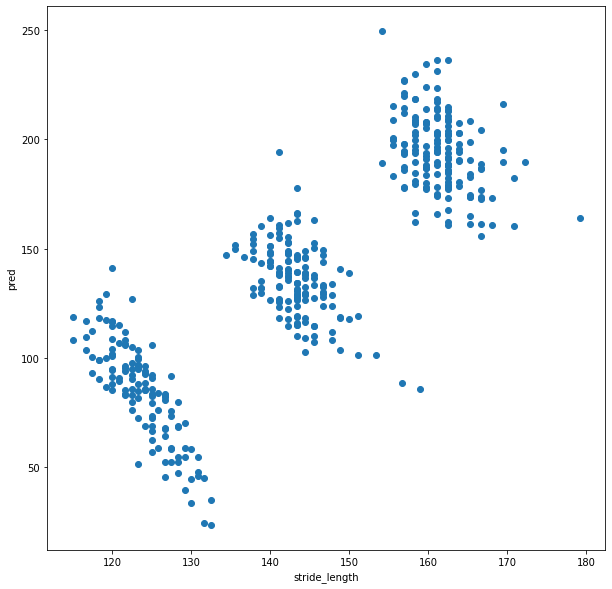

In [12]:
pred = model(inputs_acc, inputs_gyr)
pred = torch.unsqueeze(torch.sum(pred*inputs_pst, axis=1), 1).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, pred)
plt.ylabel('pred')
plt.xlabel('stride_length')

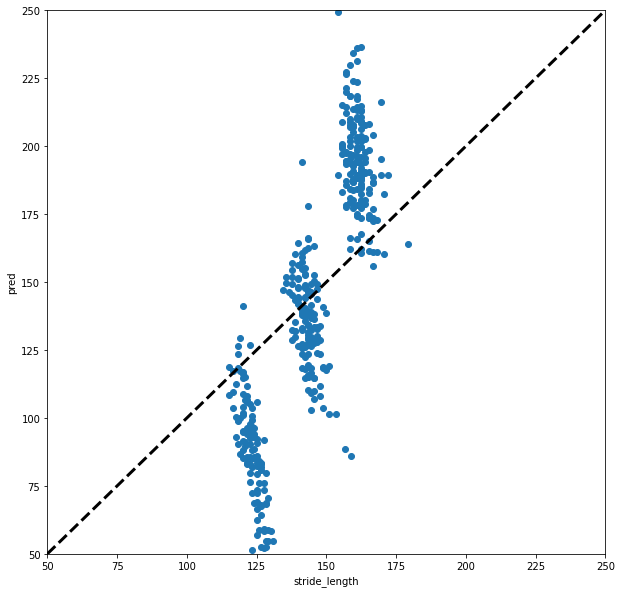

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([50, 250])
plt.xlabel('stride_length')
plt.ylim([50, 250])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : Acc, Gyro 축별 입력
- 각 축 Acc에서 얻어진 축별 distance를 곱해주기 때문에 축별로 데이터를 입력
    - 축별 Acc/Gyro의 정보가 알맞은 축의 distance와 곱해져야 한다는 생각에 시도
- 3개의 인코더에는 각각 (Acc_x, Gyro_x) / (Acc_y, Gyro_y) / (Acc_z, Gyro_z)가 입력으로 들어감
    - 인코더의 각 output을 concat한 뒤 FC-Layer에 넣었을 때, 축별 정보가 순서대로 보존될 수 있을지는 의문 부호 
- Pressure는 축이 따로 없으므로 고려하지 않음

### 데이터 불러오기

In [130]:
file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Axis_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [131]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

## Encoder

In [132]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

class Encoder_axis(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, lstm_hidden):
        super(Encoder_axis, self).__init__()
        
        self.lstm_hidden = lstm_hidden
        
        self.conv1d_x = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_dim1, hidden_dim2, 30),
            nn.ReLU(inplace=True)
        )
        
        self.conv1d_y = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_dim1, hidden_dim2, 30),
            nn.ReLU(inplace=True)
        )
        
        self.conv1d_z = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(hidden_dim1, hidden_dim2, 30),
            nn.ReLU(inplace=True)
        )
        
        self.lstm_x = nn.LSTM(hidden_dim2, lstm_hidden, 1, batch_first=True)
        self.lstm_y = nn.LSTM(hidden_dim2, lstm_hidden, 1, batch_first=True)
        self.lstm_z = nn.LSTM(hidden_dim2, lstm_hidden, 1, batch_first=True)
            
#         self.encoder_pres = nn.Sequential(
#             nn.Conv1d(input_dim, hidden_dim1, 7),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(hidden_dim1, hidden_dim2, 7),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(hidden_dim2, hidden_dim3, 7),
#             nn.ReLU(inplace=True),
#             nn.Flatten()
#         )
        
        self.dense = nn.Sequential(
            nn.Linear(lstm_hidden*3, hidden_dim2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim1, 3)
        )
        

    def forward(self, inputs_x, inputs_y, inputs_z): 
        
        h0 = torch.zeros(1, inputs_x.size(0), lstm_hidden).to(device)
        c0 = torch.zeros(1, inputs_x.size(0), lstm_hidden).to(device)
        
        conv1d_output_x = self.conv1d_x(inputs_x).transpose(1, 2)
        conv1d_output_y = self.conv1d_y(inputs_y).transpose(1, 2)
        conv1d_output_z = self.conv1d_z(inputs_z).transpose(1, 2)
        
        _, (enc_output_x, _) = self.lstm_x(conv1d_output_x)
        _, (enc_output_y, _) = self.lstm_y(conv1d_output_y)
        _, (enc_output_z, _) = self.lstm_z(conv1d_output_z)
        
        enc_output = torch.concat((enc_output_x[-1], enc_output_y[-1], enc_output_z[-1]), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [133]:
input_dim = 2
hidden_dim1 = 16
hidden_dim2 = 32
lstm_hidden = 64

model = Encoder_axis(input_dim, hidden_dim1, hidden_dim2, lstm_hidden).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [134]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = data
        inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
        inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_x, inputs_y, inputs_z)
        outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = data
            inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
            inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_x, inputs_y, inputs_z)
            outputs = torch.unsqueeze(torch.sum(outputs*inputs_pst, axis=1), 1)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './encoder_axis_best.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 17377.070126, Valid Loss 16992.949870, MAE 133.109589
Epoch : 2/2000, Train Loss : 16580.786226, Valid Loss 15353.559245, MAE 126.553596
Epoch : 3/2000, Train Loss : 13647.041946, Valid Loss 10894.582357, MAE 106.615204
Epoch : 4/2000, Train Loss : 7811.214751, Valid Loss 4172.855225, MAE 65.116913
Epoch : 5/2000, Train Loss : 2020.408316, Valid Loss 626.358490, MAE 18.348135
Best Valid Loss 626.3585
Epoch : 6/2000, Train Loss : 644.172100, Valid Loss 618.722468, MAE 15.955373
Best Valid Loss 618.7225
Epoch : 7/2000, Train Loss : 631.024420, Valid Loss 574.648682, MAE 16.167843
Best Valid Loss 574.6487
Epoch : 8/2000, Train Loss : 615.749053, Valid Loss 573.368449, MAE 16.086447
Best Valid Loss 573.3684
Epoch : 9/2000, Train Loss : 614.642511, Valid Loss 572.924037, MAE 16.028975
Best Valid Loss 572.9240
Epoch : 10/2000, Train Loss : 614.412519, Valid Loss 572.834610, MAE 16.004324
Best Valid Loss 572.8346
Epoch : 11/2000, Train Loss : 614.601458, Valid Los

Epoch : 92/2000, Train Loss : 163.215245, Valid Loss 150.175755, MAE 6.552095
Epoch : 93/2000, Train Loss : 156.184963, Valid Loss 139.503328, MAE 5.923499
Best Valid Loss 139.5033
Epoch : 94/2000, Train Loss : 155.174112, Valid Loss 143.030033, MAE 6.187194
Epoch : 95/2000, Train Loss : 160.022109, Valid Loss 153.650609, MAE 7.175807
Epoch : 96/2000, Train Loss : 160.723704, Valid Loss 135.528113, MAE 5.718766
Best Valid Loss 135.5281
Epoch : 97/2000, Train Loss : 156.667571, Valid Loss 132.113414, MAE 5.659029
Best Valid Loss 132.1134
Epoch : 98/2000, Train Loss : 151.322894, Valid Loss 141.308025, MAE 6.359222
Epoch : 99/2000, Train Loss : 156.203016, Valid Loss 134.509879, MAE 5.589938
Epoch : 100/2000, Train Loss : 152.097682, Valid Loss 151.830912, MAE 6.590162
Epoch : 101/2000, Train Loss : 150.237360, Valid Loss 135.309378, MAE 5.958851
Epoch : 102/2000, Train Loss : 155.261900, Valid Loss 141.346446, MAE 6.657311
Epoch : 103/2000, Train Loss : 155.045459, Valid Loss 137.667358

## Scatter Plot

In [136]:
file_path = "D:\gait_dataset/salted/test/*"
inputs_x, inputs_y, inputs_z, stride_length = get_axis_sensor_salted(file_path)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = torch.Tensor(np.array(inputs_x)), torch.Tensor(np.array(inputs_y)), torch.Tensor(np.array(inputs_z)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)

# stride_length = stride_length.reshape(-1, 1)
# stride_length = stride_length.to(device)

In [138]:
input_dim = 2
hidden_dim1 = 16
hidden_dim2 = 32
lstm_hidden = 64

model = Encoder_axis(input_dim, hidden_dim1, hidden_dim2, lstm_hidden).to(device)
model.load_state_dict(torch.load('./encoder_axis_best.pth'))
model.eval()

Encoder_axis(
  (conv1d_x): Sequential(
    (0): Conv1d(2, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
  )
  (conv1d_y): Sequential(
    (0): Conv1d(2, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
  )
  (conv1d_z): Sequential(
    (0): Conv1d(2, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
  )
  (lstm_x): LSTM(32, 64, batch_first=True)
  (lstm_y): LSTM(32, 64, batch_first=True)
  (lstm_z): LSTM(32, 64, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=192, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)

Text(0, 0.5, 'stride_length')

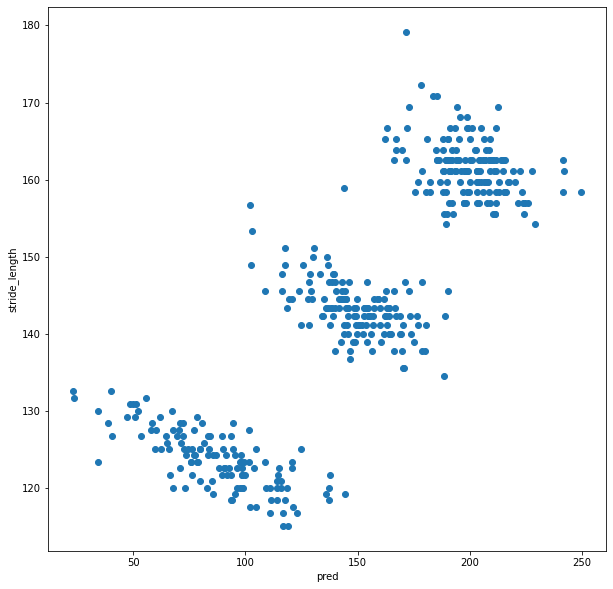

In [139]:
pred = model(inputs_x, inputs_y, inputs_z)
pred = torch.unsqueeze(torch.sum(pred*inputs_pst, axis=1), 1).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(pred, stride_length)
plt.xlabel('pred')
plt.ylabel('stride_length')